# 1. Data preprocessing

## a) Dataset 

In [1]:
from google.colab import drive
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd 
import warnings
import numpy as np
import sys
import os
py_file_location = "drive/MyDrive/Datamining"
sys.path.append(os.path.abspath(py_file_location))
warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format
# pre-downloaded dataset
df=pd.read_csv(py_file_location+'/stock_prices2.csv')

df.rename(columns = {'Unnamed: 0':'Date'}, inplace = True)
df=df.drop([1])
df.set_index('Date', inplace=True)
# print(df)

In [4]:
use_col = [col_name for col_name in list(df.columns) if col_name.startswith('Adj Close')]
# get all adjusted close price out
data = df.loc[:,use_col]
# change columns' names
data.columns = data.iloc[0]
data.columns.name = ''
data = data.filter(regex='(?i)^(?!NaN).+', axis=0)
# convert all type to float
data = data.astype(float)
# delete null columns 
nullcols = data.columns[data.isna().any()].tolist()
data = data.drop(nullcols, axis=1)
# ticker names
assets = data.columns.values
# percentage change daily
data = np.log1p(data[assets].pct_change().dropna()+1)
print(data)

                           A      AAL      AAP     AAPL     ABBV      ABC  \
Date                                                                        
2016-01-05 00:00:00 69.1425% 68.8369% 68.9726% 68.0538% 69.1062% 70.0434%   
2016-01-06 00:00:00 69.5364% 70.1870% 67.9831% 68.3314% 69.3234% 68.5475%   
2016-01-07 00:00:00 67.1681% 68.3643% 69.8669% 67.1819% 69.1665% 67.7053%   
2016-01-08 00:00:00 68.7877% 69.2158% 68.2101% 69.5788% 67.9419% 69.0250%   
2016-01-11 00:00:00 68.4690% 70.1902% 69.8252% 70.1211% 67.7116% 67.3040%   
...                      ...      ...      ...      ...      ...      ...   
2019-12-20 00:00:00 69.7162% 70.1692% 69.8374% 69.2111% 69.6072% 70.4243%   
2019-12-23 00:00:00 69.3558% 69.7614% 69.8980% 70.1273% 69.8508% 69.2739%   
2019-12-24 00:00:00 69.3382% 69.1097% 69.5021% 69.3622% 69.0929% 69.2095%   
2019-12-26 00:00:00 69.4026% 70.1508% 68.9091% 70.3018% 69.3036% 69.0979%   
2019-12-27 00:00:00 69.2972% 67.2201% 69.0255% 69.2957% 68.9634% 69.2324%   

## b) GICS cluster

In [5]:
def encode(labels):
    # return a list of encode labels inform of incremental integers
    return [np.where(np.array(list(dict.fromkeys(labels)))==e)[0][0]for e in labels]

In [6]:
payload = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = pd.DataFrame(payload[0])
tickers = df['Symbol'].values.tolist()
GICS_sectors = df['GICS Sector'].values.tolist()
# convert sector name to some number
encoded_sectors = encode(GICS_sectors)
pair_GICS = list(zip(tickers, encoded_sectors))


In [7]:
from copy import deepcopy
sorted_pairs = sorted(deepcopy(pair_GICS), key=lambda x:x[0])
# drop na keys
dropna_pairs = list(filter(lambda x: x[0] not in nullcols, sorted_pairs))
# find true labels
true_labels = np.array([x[1] for x in dropna_pairs])
num_sectors = np.max(true_labels)+1 # number of sectors

# 2. Hierarchical Clustering

### a) Import setup

In [8]:
!pip install cvxpy
!pip install pybind11
!pip3 install riskfolio-lib
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.3/222.3 kB 6.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.2/220.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.7/152.7 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.5/920.5 kB 39.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import matplotlib.pyplot as plt
import riskfolio as rp
import riskfolio.src.DBHT as db
import scipy.cluster.hierarchy as hr
from scipy.spatial.distance import squareform
from plotutils import *
from random import sample
from sklearn.metrics.cluster import adjusted_rand_score

### b) Application on US stocks

pearson  single: 0.0012848518315003443
pearson  complete: 0.18434831870702692
pearson  average: 0.07793230454526393
pearson  ward: 0.41776446389853966
pearson single DBHT: 0.1823795603856937
pearson complete DBHT: 0.3145881558224326
pearson ward DBHT: 0.3655309372056351
spearman  single: 0.0022309516818048345
spearman  complete: 0.24223748662447164
spearman  average: 0.08036247713995139
spearman  ward: 0.44603027470630896
spearman single DBHT: 0.14169922434336474
spearman complete DBHT: 0.37013987082163774
spearman ward DBHT: 0.38840950507476374


[]

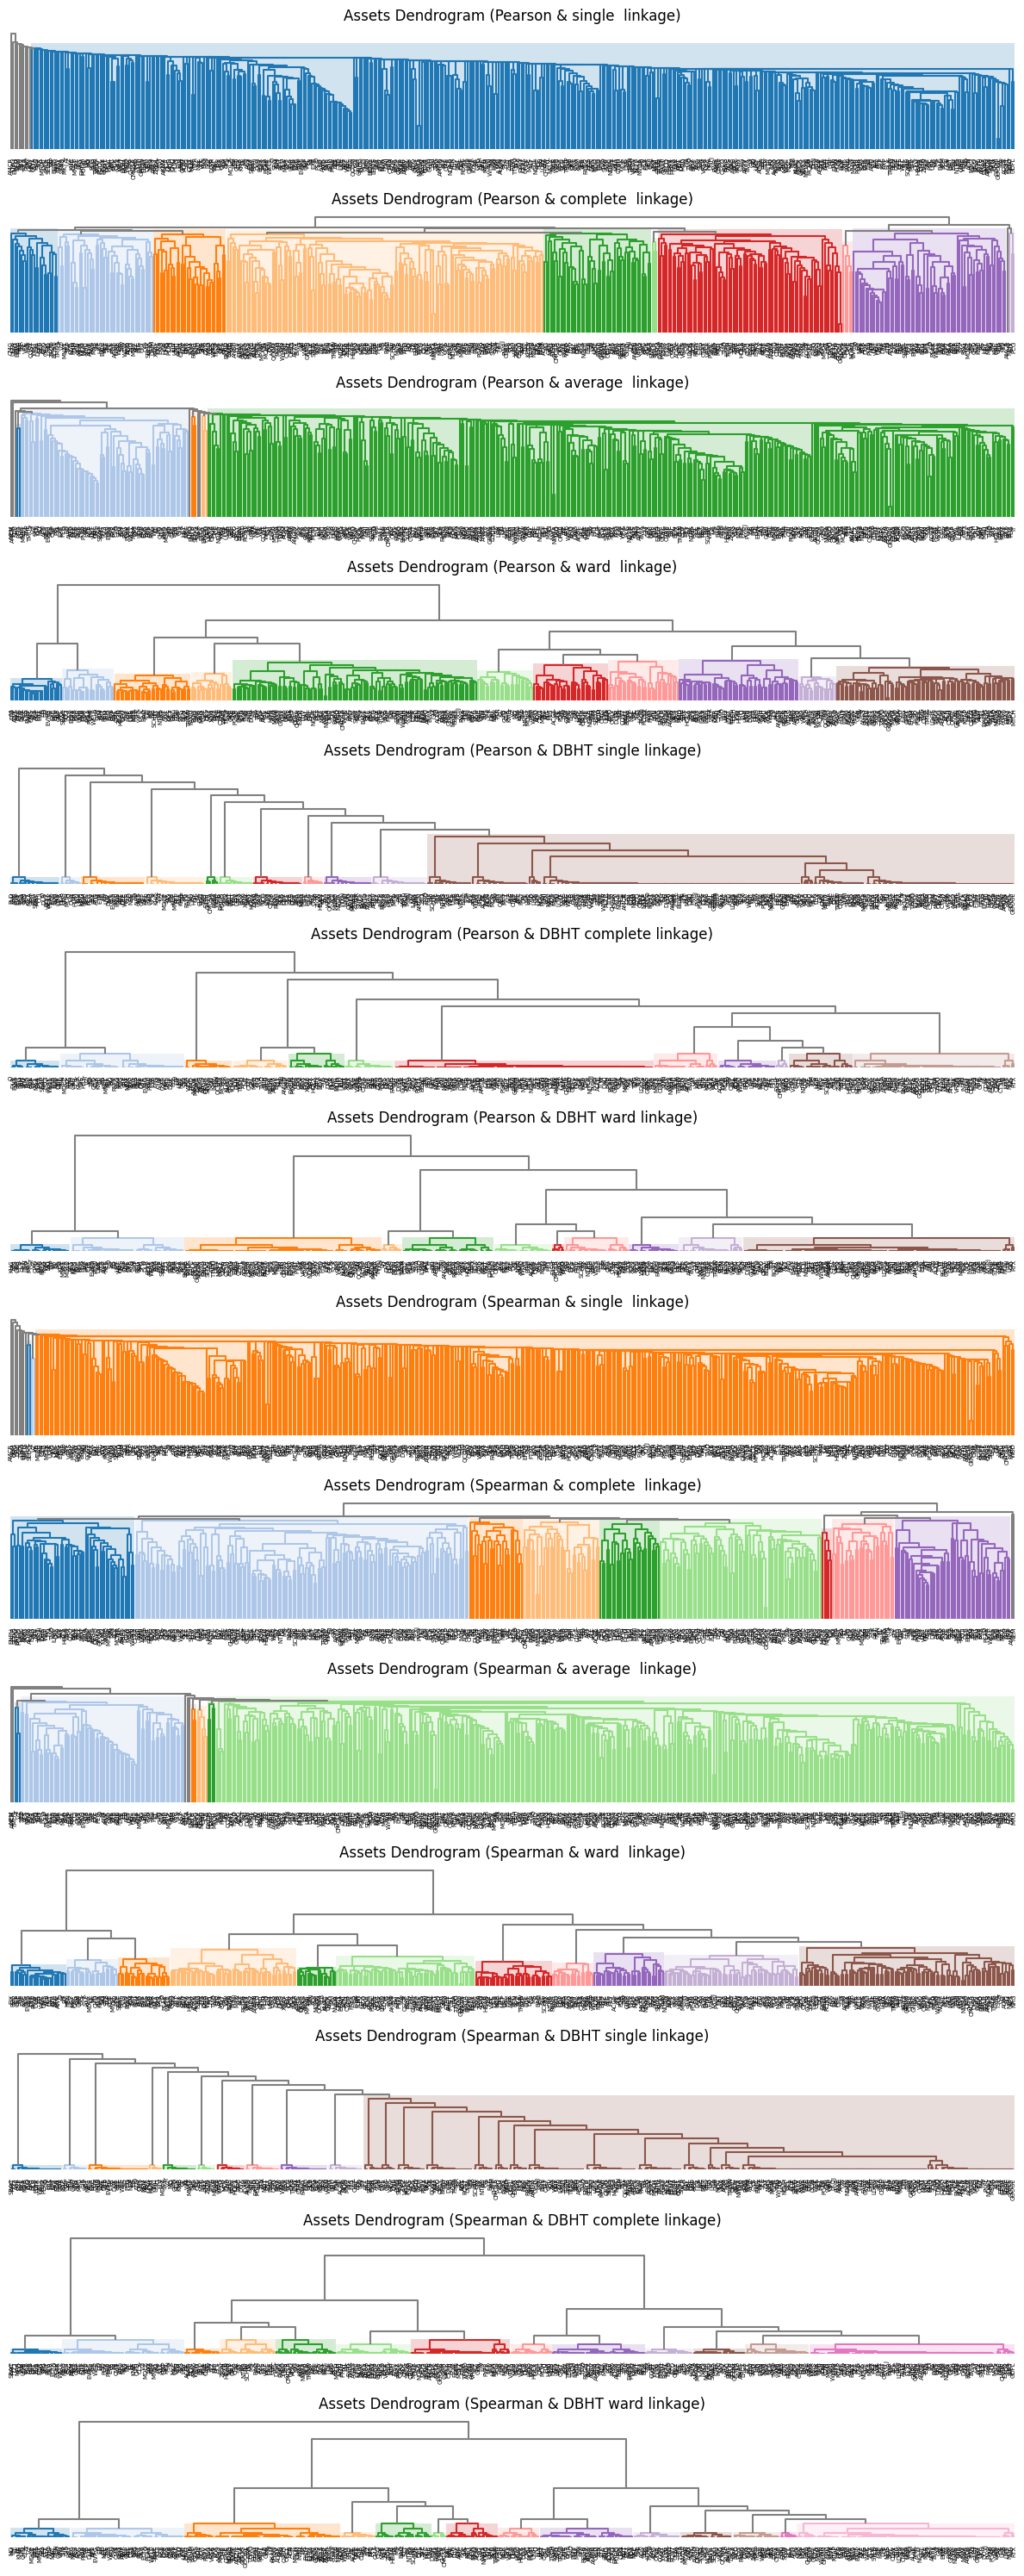

In [10]:
# Comparison of several linkages methods
linkages = ['single','complete','average', 'ward', 'DBHTsingle', 'DBHTcomplete', 'DBHTward']
codeps = ['pearson', 'spearman']

fig, ax = plt.subplots(len(linkages)*len(codeps), 1, figsize=(12, 30))
ax = np.ravel(ax)
leaf_order = False

# sample a subset of original ticker set to test
# randset = sample(range(len(assets)), 100)
randset = range(len(assets))
sub_tickers = assets[randset]
truth = true_labels[randset]
# adj sub set
temp = data[sub_tickers]

for i, codep in enumerate(codeps):
    for j, linkage in enumerate(linkages): 
        if 'DBHT' in linkage:
            method = linkage[4:]
            linkage = 'DBHT'
        else: method = ''
        
        ax[i*len(linkages)+j], R = plot_dendro(returns=temp,
                                codependence=codep,
                                linkage=linkage,
                                k=num_sectors,
                                max_k=20,
                                leaf_order=leaf_order,
                                ax=ax[i*len(linkages)+j],
                                method=method)
    
        pred_tickers = sub_tickers[R['leaves']]        
        enc = encode(R['leaves_color_list'])
        label_dict = dict(zip(pred_tickers, enc))
        pred_labels = [label_dict[ticker] for ticker in sub_tickers]

        ari = adjusted_rand_score(pred_labels, truth)
        print(codep+' '+ method+' '+linkage+': '+str(ari))
plt.plot()

## c) Clarify Correlation Matrix (Matrix Seriation)

In [11]:
# sample a subset of original ticker set to test
# randset = sample(range(len(assets)), 100)
randset = range(len(assets))
sub_tickers = assets[randset]
truth = true_labels[randset]
# adj sub set
temp = data[sub_tickers]

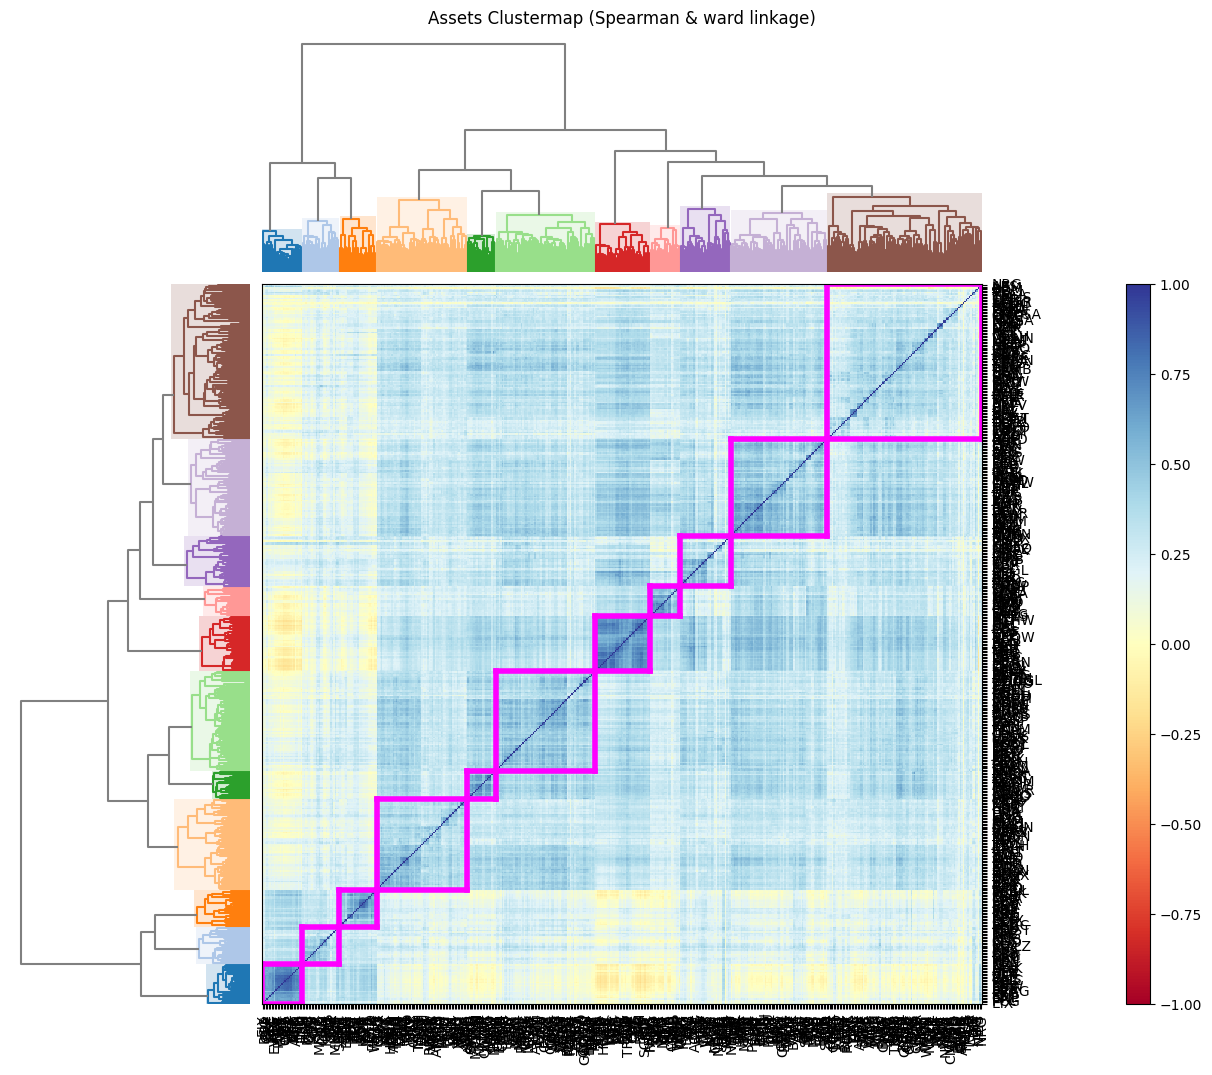

In [ ]:
ax = plot_clus(returns=temp, codependence='spearman',
                      linkage='ward', k=num_sectors, max_k=20,
                      leaf_order=False, dendrogram=True, ax=None, method=None)

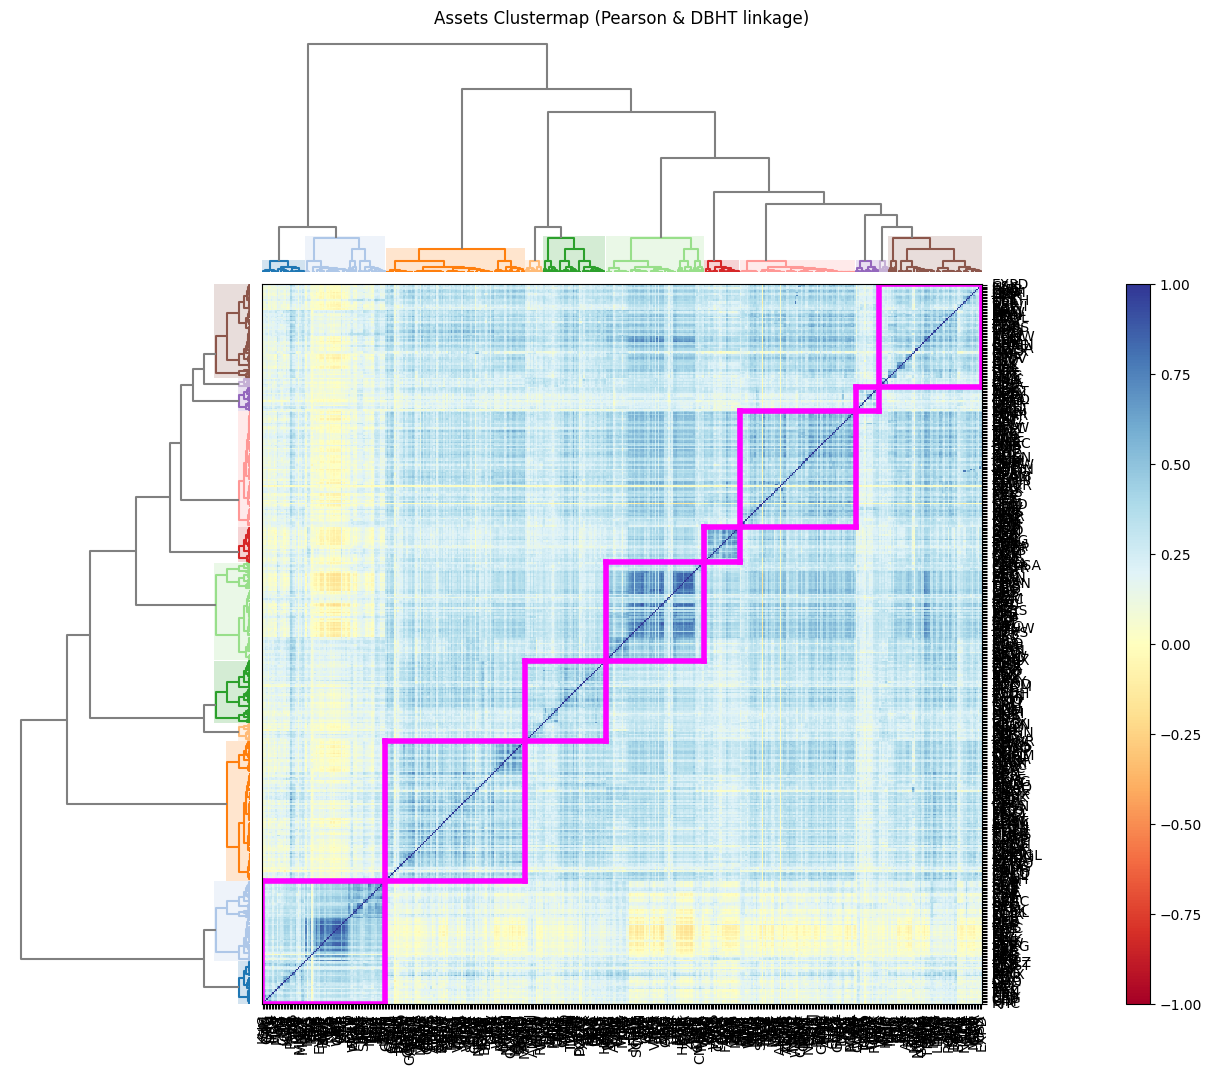

In [ ]:
ax = plot_clus(returns=temp, codependence='spearman',
                      linkage='DBHT', k=num_sectors, max_k=20,
                      leaf_order=False, dendrogram=True, ax=None, method='ward')

#3. Portfolio Construction

## a) Visualize sub-network

[]

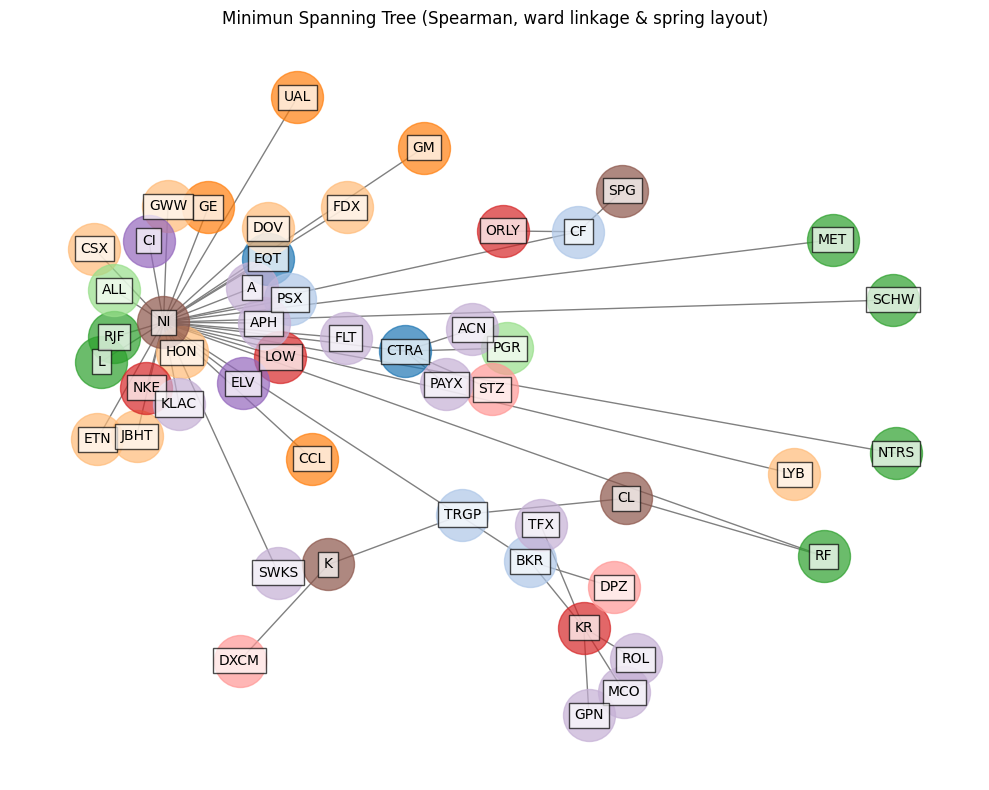

In [ ]:
randset = sample(range(len(assets)), 50)
# randset = range(len(assets))
sub_tickers = assets[randset]
truth = true_labels[randset]
# adj sub set
temp = data[sub_tickers]

ax = rp.plot_network(returns=temp, codependence="spearman",
                     linkage="ward", k=num_sectors, max_k=10,
                     alpha_tail=0.05, leaf_order=True,
                     kind='spring', ax=None)
plt.plot()

## b) Portfolio Optimization Using HRP

In [ ]:
randset = sample(range(len(assets)), 50)
# randset = range(len(assets))
sub_tickers = assets[randset]
truth = true_labels[randset]
# adj sub set
temp = data[sub_tickers]

# Building the portfolio object
port = rp.HCPortfolio(returns=temp)

# Estimate optimal portfolio:

model='HRP' # Could be HRP or HERC
codependence = 'spearman' # Correlation matrix used to group assets in clusters
rm = 'MV' # Risk measure used, this time will be variance
rf = 0 # Risk free rate
linkage = 'ward' # Linkage method used to build clusters
max_k = 20 # Max number of clusters used in two difference gap statistic, only for HERC model
leaf_order = False # Consider optimal order of leafs in dendrogram

w = port.optimization(model=model,
                      codependence=codependence,
                      rm=rm,
                      rf=rf,
                      linkage=linkage,
                      k=num_sectors,
                      max_k=max_k,
                      leaf_order=leaf_order)

display(w.T)

,FRC,AKAM,MPC,LYV,TAP,ETSY,TYL,CAT,NEE,ON,...,KMI,TDY,KLAC,ES,NFLX,MNST,DIS,TFX,STX,ALLE
weights,1.6869%,0.5985%,1.2555%,1.3787%,3.0516%,0.3214%,1.0300%,0.9900%,5.2134%,0.5510%,...,1.1333%,1.8536%,0.9082%,6.2789%,0.5480%,2.5293%,3.8081%,1.9347%,0.7061%,1.9327%


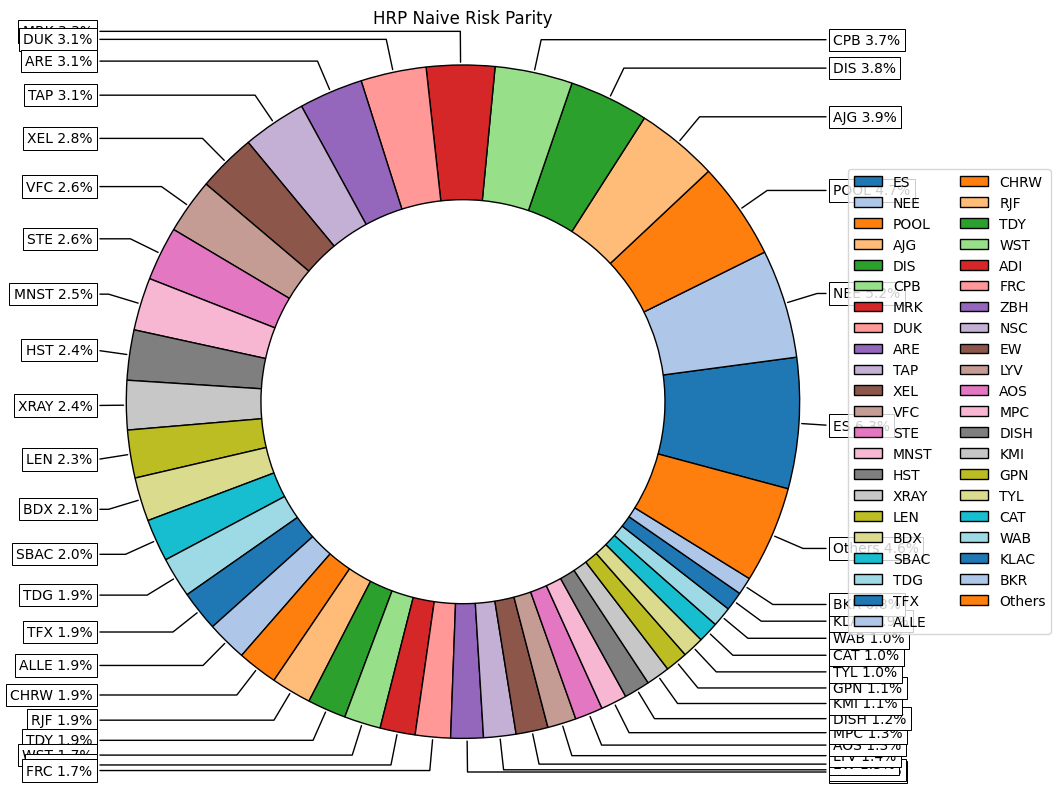

In [ ]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w,
                 title='HRP Naive Risk Parity',
                 others=0.05,
                 nrow=25,
                 cmap="tab20",
                 height=8,
                 width=10,
                 ax=None)

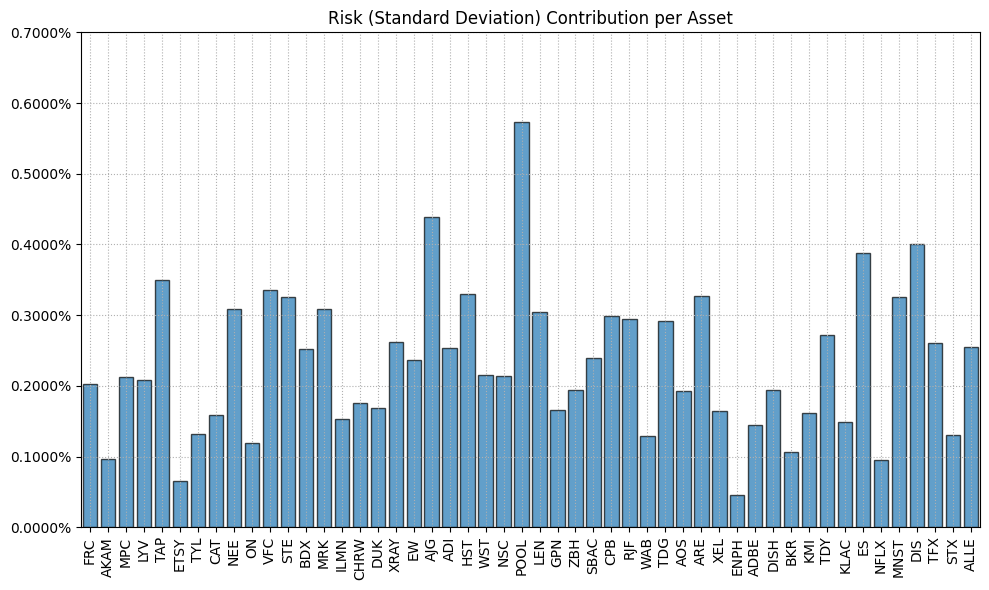

In [ ]:
# Plotting the risk contribution per asset

mu = temp.mean()
cov = temp.cov() # Covariance matrix
returns = temp # Returns of the assets

ax = rp.plot_risk_con(w=w,
                      cov=cov,
                      returns=returns,
                      rm=rm,
                      rf=0,
                      alpha=0.05,
                      color="tab:blue",
                      height=6,
                      width=10,
                      t_factor=252,
                      ax=None)

# Appendix A: Code snippet to download the original dataset

In [ ]:
# import pandas as pd 
# import yfinance as yf
# import datetime
# payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
# first_table = payload[0]
# df = first_table
# df.head()
# tickers_symbols=df['Symbol'].values.tolist()
# GICS_sectors = df['GICS Sector'].values.tolist()
# GICS=pd.DataFrame(GICS_sectors)
# start = '2016-01-01'
# end = '2019-12-30'
# data = yf.download(tickers_symbols, start=start, end=end)
# data['GICS']=GICS
# print(data.head)
# data.to_csv('stock_prices2.csv')